# Project workflow is as follows

![title](First_Agent2.jpg))


- If the user question is about "US" then the answer should use the Context loaded within VectorDB
- If the user question is about "India" then the answer should be using WebCrawler. 
- For rest of the questions we should use LLM Calls.

## Importing the required libraries

In [125]:
#Importing libraries
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma 
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_tavily import TavilySearch, TavilyExtract
import os 
import numpy as np 
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np 


# Loading the VectorDB 

In [78]:
#Define the Embedding model 
from langchain_huggingface import HuggingFaceEmbeddings

#Create the embedding model 
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")

In [79]:

#Read the input file onto loader object (Directory Loader + Text loader)
loader = DirectoryLoader("../data", glob="./*.txt", loader_cls=TextLoader, show_progress=True)

#Perform Load operation
docs = loader.load()

#Splitting the document into chunks 
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200, 
    chunk_overlap=50
)

#Perform Splitting operation 
new_docs = text_splitter.split_documents(documents=docs)

#Creating DB Instance (Chroma)
db = Chroma.from_documents(new_docs, embeddings)

#Creating a retriver object
retriver = db.as_retriever(search_kwargs={"k":3})



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 251.85it/s]


In [80]:
#Function to collect the text from the document retrived from retriver so that 
def format_docs(docs):
    return "\n \n".join(doc.page_content for doc in docs)

# Pydantic Model and AgenticState

In [81]:
#Import Pydantic library
from pydantic import BaseModel, Field 

#Defining the Pydantic class 
class TopicSelectionParser(BaseModel):
    Topic : str = Field(description="Identified Topic from user input")
    Reasoning : str = Field(description= "Rationale or Reason for selecting the topic from the user input")

In [82]:
#Attaching the Pydantic Class to Parser output 
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [83]:
#Defining Agent State
class AgentState(TypedDict): 
    messages : Annotated[Sequence[BaseMessage], operator.add]

# Defining the model 

In [84]:
#Building the model 
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

# Define the Supervisor Model 

In [85]:
#Defining the function (Supervisor) 

def function_1(state: AgentState):
    
    #Identify the node that executes the task 
    print("------> Supervisor <-----------")
    
    #Capturing the user question 
    #Taking the last message as the recent user question 
    question = state["messages"][-1] 
    
    #Display the question 
    print("Question is : ", question)
    
    #Next is to define the input to the LLM. 
    template = """ 
    Your task is to clarify if the given user query into the following categories : [USA, INDIA, Not Related].
    Only respond with the Category Name and Nothing else. 
    
    User question : {question}
    
    {format_instructions}
     
    """
    
    #Creating Prompt for LLM 
    prompt = PromptTemplate(
        template=template, 
        input_variables=["question"],
        partial_variables={"format_instructions":parser.get_format_instructions()}
    )
    
    #Creating the chain 
    chain = prompt | model | parser 
    
    #Executing the Chain 
    response = chain.invoke({"question : ", question })
    
    #Display the response 
    print("Parsed response from Supervisor : ", response)
    
    #Returning state 
    return{"messages" : [response.Topic]}  


# Defining RAG

- This module will be trigged if the Question is about USA 
- We will retrive the answer from the Vector DB.

In [86]:
#RAG Function : Function 2 
def function_2(state: AgentState):
    
    #Identify the node that performs the execution 
    print("============> RAG Node <======================")
    
    #Identifying the user question as the fist message
    question = state["messages"][0]
    
    #Defining the Prompt to execute 
    prompt = PromptTemplate(
        
        #Defining a RAG Template
        template= """ 
        You are an assistant for answering the given question and provide accurate answers. 
        Use the following pieces retrieved from the context to answer the question. 
        If you dont know the answer, then you just say that you dont know the answer. 
        Use a maximum of three sentences to answer the question.
        
        \n 
        Question : {question} 
        
        \n
        Context : {context}
        
        \n
        Answer : 
        """ ,
        input_variables=['context', 'question']
    )
    
    #Building the RAG Chain 
    rag_chain = (
        {"context": retriver | format_docs, "question": RunnablePassthrough()}
        |   prompt 
        |   model 
        |   StrOutputParser()     
    )

    #Generating Result 
    result = rag_chain.invoke(question)

    #Return message
    return {"messages": [result]}
    

# Defining LLM Call

In [87]:
#LLM Call 
def function_3(state: AgentState):
    
    #Identifying the node that is executing 
    print("===========> LLM Call <=====================")
    
    #Getting the user question 
    question = state["messages"][0]
    
    #User question is passed onto the model to get the response 
    complete_query = "Answer the following question with your knowledge of the reason world. The question is  " + question 
    
    #Generating LLM Response 
    response = model.invoke(complete_query)
    
    #Result from LLM 
    return{"messages": [response.content]}

# Define WebCrawler 

- This module will be triggered if the question is about India. 
- We use Travly to search and extract the relevant detail.

In [88]:
#This function will search and extract details of Topic shared to it  


def function_4(state: AgentState):
    
    #Identify that the node that is performing the operation 
    print("========================> WebCrawling <=============================")
    
    #Capturing the user question as it will be the first message 
    question = state["messages"][0]
    
    #Perfoming the search in the internet using the user question 
    tavily_search = TavilySearch(api_key=os.getenv('TAVILY_API_KEY'), max_results=5, topic="general" ) 
    search_results = tavily_search.invoke(question)
    
    #Extract the URLs alone from the abvoe search result 
    urls = [item["url"] for item in search_results["results"]]
    
    #Share the URLs to extract the relevant information from Websites identified. 
    tavily_extract = TavilyExtract(api_key=os.getenv('TAVILY_API_KEY'), extract_depth="basic", include_images=False)
    result = tavily_extract.invoke({"urls" : urls})
    raw_context = [item["raw_content"] for item in result["results"]]  


    #Defining the prompt template 
    template = """ 
    Your task is to summarise the data provided based on extracted information against user question that is asked. 
    
    \n
    User Question is available here : {question}
    
    \n 
    The context that should be used to summrise for the question above is available here: {raw_context}
    """
    
    #Prompt Template 
    prompt = PromptTemplate(
        template=template,
        input_variables=["raw_context", "question"]
    )
    
    #Define an llm Chain 
    LLM_Chain = prompt | model | StrOutputParser() 
    
    #Generating result 
    result = LLM_Chain.invoke({"question":question, "raw_context": raw_context})
    
    #Return Message
    return {"messages" : [result]}
    

In [89]:
#Testing the function 4 
#Input  
state={"messages":["Can you tell me about India?"]}
result = function_4(state)
import pprint
pprint.pprint(result["messages"])

========================> WebCrawling <=============================
["India, officially the Republic of India, is a South Asian country.  It's the "
 "world's most populous country (as of 2023) and the seventh largest by area.  "
 "Independent since 1947, it's the world's largest democracy.  Its diverse "
 'geography includes the Indian Ocean to the south, the Arabian Sea to the '
 'southwest, and the Bay of Bengal to the southeast.  It shares land borders '
 'with Pakistan, China, Nepal, Bhutan, Bangladesh, and Myanmar.  \n'
 '\n'
 "India's history stretches back to the arrival of modern humans at least "
 '55,000 years ago.  Significant periods include the Indus Valley Civilization '
 '(2500–1900 BCE), the Mauryan and Gupta empires, and the Mughal Empire.  '
 'British colonial rule lasted from 1858 until independence in 1947, followed '
 'by partition into India and Pakistan.\n'
 '\n'
 'Since 1950, India has been a federal parliamentary republic with a '
 'multi-party system.  Its e

# Define Validation

- Here i want to perform Validation and if the validation fails i want the control to go back to Supervisor node. 
- If the Validation is successful then it should go to exit. 

In [ ]:
#Building a function that takes the question and the final answer and check their 


def function_5(state: AgentState): 
    
    #Identify the node that perform the execution 
    print("==================> Validation <===================")
    
    #Identify the user question (first message) 
    question = state["messages"][0]
    
    #Convert input into Embedding 
    question_embedding = embeddings.embed_query(question)
    
    
    #Getting the last result generated 
    result = state["messages"][-1]
    
    #Convert result into embedding
    result_embdding = embeddings.embed_query(result)
    
    #Reshaping the embeddings for calculating simillarity score
    question_embedding = np.array(question_embedding).reshape(1, -1)
    result_embdding = np.array(result_embdding).reshape(1, -1)
    
    #Perform a simillarity score between Question and Result 
    simillarity_score = cosine_similarity(question_embedding, result_embdding)
    
    #Reshaping the embeddings for calculating simillarity score
    
    #Display Simillarity score
    print("Simillarity Score is ", simillarity_score)
    
    if simillarity_score > .5 : 
        print("Q&A are highly simillar")
        response_var = "Successful Validation"
    else: 
        print("Q&A are not simillar")
        response_var = "Unsuccessful Validation"
    
    return{"messages":[response_var]}    



In [111]:
#Validating function 
#Input  
state={"messages":["Where is Paris located? ", "Lets speak something else ","Paris is in France"] }

result = function_5(state)
import pprint
pprint.pprint(result["messages"])

==================> Validation <===================
Simillarity Score is  [[0.93548803]]
Q&A are highly simillar
['Successful Validation']


# Define : Router 1 

- This will take the output of Supervisor and decide which node to execute. 

In [113]:
def router1(state: AgentState): 
    
    #Identifying the node where we are in 
    print("==============> Router 1 <======================")
    
    #Fetching the output from the supervisor (output  from Supervisor )
    last_message = state["messages"][-1]
    
    #Display the message received 
    print("Message Received by Router 1 ", last_message)
    
    #Establishing the Routing Rules 
    if "usa" in last_message.lower(): 
        return "RAG Call"
    elif "india" in last_message.lower(): 
        return "Web Call"
    else:
        return "LLM Call"
    

# Define Router 2 

- This takes the output of Validation node and decide next steps. 

In [115]:
def router2(state: AgentState): 
    
    #Identifying the node where we are in 
    print("==============> Router 3 <======================")
    
    #Fetching the output from the supervisor (output  from Supervisor )
    last_message = state["messages"][-1]
    
    #Display the message received 
    print("Message Received by Router 1 ", last_message)
    
    #Establishing the Routing Rules 
    if "successful validation" in last_message.lower(): 
        return "Success Call"
    else:
        return "Fail Call"

# Define the workflow 

In [120]:
#Importing the required libraries 
from langgraph.graph import StateGraph, END 

#Creating the StateGraph as Workflow 
workflow = StateGraph(AgentState)

#Adding nodes 
workflow.add_node("Supervisor", function_1)
workflow.add_node("RAG", function_2)
workflow.add_node("LLM", function_3)
workflow.add_node("WEB", function_4)
workflow.add_node("Validation", function_5)

#Define Entry Point
workflow.set_entry_point("Supervisor")

#Defining Conditional Edges
workflow.add_conditional_edges(
    "Supervisor", 
    router1,
    {
        "RAG Call" : "RAG", 
        "LLM Call" : "LLM", 
        "Web Call" : "WEB" 
    }
)

# After RAG, LLM, or WEB, the flow should go to Validation
workflow.add_edge("RAG", "Validation")
workflow.add_edge("LLM", "Validation")
workflow.add_edge("WEB", "Validation")

#Defining Conditional Edges
workflow.add_conditional_edges(
    "Validation", 
    router2, 
    {
        "Success Call" : END, 
        "Fail Call" : "Supervisor" 
        
    }
)

#Compile the workflow to create the app 
app=workflow.compile()

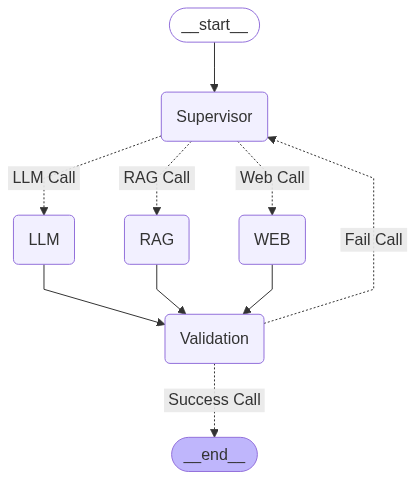

In [121]:
#Display the workflow 
workflow.compile()

# Testing the output

In [123]:
#Creating input 
state={"messages":["What is the Population of Singapore? "]}

#Executing the app 
app.invoke(state)

------> Supervisor <-----------
Question is :  What is the Population of Singapore? 
Parsed response from Supervisor :  Topic='Not Related' Reasoning='The question is about the population of Singapore, which is not related to the USA or INDIA.'
==============> Router 1 <======================
Message Received by Router 1  Not Related
===========> LLM Call <=====================
==================> Validation <===================
Simillarity Score is  [[0.93165067]]
Q&A are highly simillar
==============> Router 3 <======================
Message Received by Router 1  Successful Validation


{'messages': ['What is the Population of Singapore? ',
  'Not Related',
  'The population of Singapore is not a static number and fluctuates.  However, as of late 2023, the population of Singapore is approximately **5.7 to 5.8 million**.  This figure is an estimate, and precise figures vary slightly depending on the source and the date of the data collection.',
  'Successful Validation']}

In [124]:
#Creating input 
state={"messages":["What is the Population of Indian? "]}

#Executing the app 
app.invoke(state)

------> Supervisor <-----------
Question is :  What is the Population of Indian? 
Parsed response from Supervisor :  Topic='INDIA' Reasoning="The user explicitly mentions 'Indian' population, which directly relates to India."
==============> Router 1 <======================
Message Received by Router 1  INDIA
========================> WebCrawling <=============================
==================> Validation <===================
Simillarity Score is  [[0.88647645]]
Q&A are highly simillar
==============> Router 3 <======================
Message Received by Router 1  Successful Validation


{'messages': ['What is the Population of Indian? ',
  'INDIA',
  'Based on the provided text, the population of India in 2023 is estimated to be 1,438,069,597.  Different sources provide slightly varying figures for 2025, ranging from 1,454,606,724 to 1,463,865,525.  The population is constantly increasing, though the growth rate is slowing.',
  'Successful Validation']}